In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf  # auto-correkation
from statsmodels.tsa.stattools import adfuller as ADF  # test of stationarity
from statsmodels.graphics.tsaplots import plot_pacf    # partial auto-correlation
# from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA 

# Load and clean dataset

In [47]:
date_index = pd.read_csv("../data/BTC_daily_ARIMA.csv")["Date"]
date_index = date_index.iloc[::-1]

In [48]:
file_list_hour = ["../data/BTC_hourly_ARIMA.csv", "../data/gemini_BTCUSD_1hr.csv", "../data/gemini_ETHBTC_1hr.csv", "../data/gemini_ETHUSD_1hr.csv", 
"../data/gemini_LTCUSD_1hr.csv", "../data/gemini_ZECBTC_1hr.csv", "../data/gemini_ZECETH_1hr.csv", "../data/gemini_ZECUSD_1hr.csv"]
df = []

for i in range(len(file_list_hour)):
    df.append(pd.read_csv(file_list_hour[i]))


df_close_hour = np.array(df[0]['Close'])[::-1]
df_high_hour = np.array(df[0]['High'])[::-1]
df_low_hour = np.array(df[0]['Low'])[::-1]
df_volume_hour = np.array(df[0]['Volume'])[::-1]
vwap = []
residual = (df_close_hour.size) % 24

In [49]:
for i in range(df_close_hour.size//24):

    close_hour_sub = df_close_hour[i*24 + residual: (i+1)*24 + residual] #list of 24

    high_hour_sub = df_high_hour[i*24 + residual: (i+1)*24 + residual ] #list of 24

    low_hour_sub = df_low_hour[i*24 + residual : (i+1)*24 + residual ] #list of 24

    volume_hour_sub = df_volume_hour[i*24 + residual : (i+1)*24 + residual ] # 24hr trade volumes list of 24

    average_hour_sub = ((close_hour_sub + high_hour_sub + low_hour_sub)/3) * volume_hour_sub #list of 24
    
    if sum(volume_hour_sub) == 0:
        vwap_day = close_hour_sub[0]
    else:
        vwap_day = sum(average_hour_sub)/sum(volume_hour_sub)

    vwap.append(vwap_day)

vwap = pd.Series(vwap, index=date_index)
vwap.name = "Vwap"

# Exploratory data analysis

<AxesSubplot:xlabel='Date'>

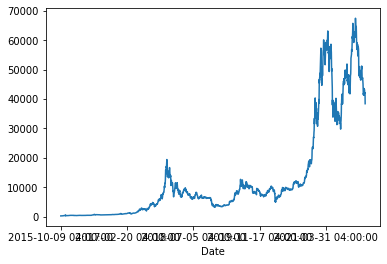

In [66]:
data.plot()

C:\Users\XTM233\AppData\Local\Temp/ipykernel_12428/1137652694.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data).show()


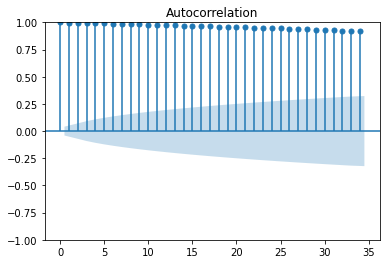

In [63]:
plot_acf(data).show()

In [53]:
ADF(data)

(-1.2500162459463064,
 0.6517187292684101,
 27,
 2269,
 {'1%': -3.433235285765301,
  '5%': -2.862814646891805,
  '10%': -2.5674485535435454},
 36202.65552977727)

It can be seen that non stationarity exists in the time series data. Hence, we explore further by taking the differences between each two neighbouring data point to form a new sequence.

<AxesSubplot:xlabel='Date'>

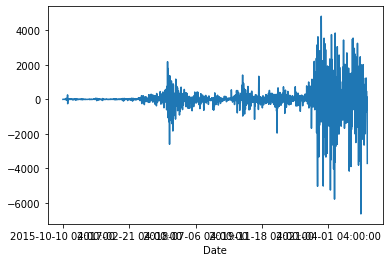

In [55]:
D_data = data.diff().dropna()
D_data.plot()

C:\Users\XTM233\AppData\Local\Temp/ipykernel_12428/2538248294.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data).show()


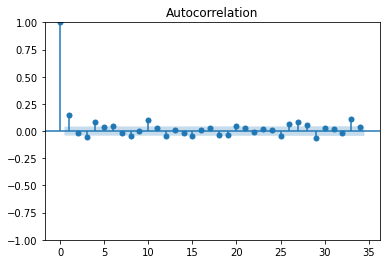

In [56]:
plot_acf(D_data).show()

In [57]:
ADF(D_data)

(-7.176881553430234,
 2.7127387504411983e-10,
 27,
 2268,
 {'1%': -3.43323655938138, '5%': -2.86281520927122, '10%': -2.567448852970086},
 36183.67693162202)

C:\Users\XTM233\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


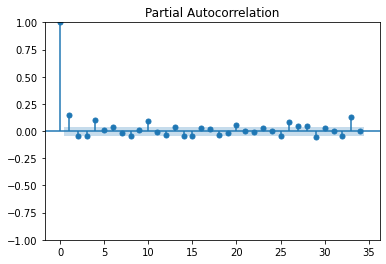

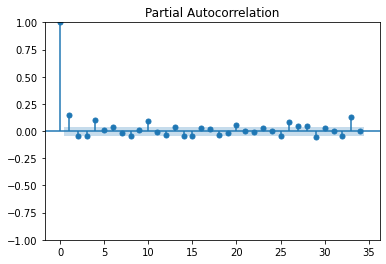

In [58]:
plot_pacf(D_data)

In [59]:
pmax = int(len(D_data)/10)
qmax = int(len(D_data)/10)

Plotting the data. First for  `gemini_BTCUSD_day`

In [67]:
import optuna

training_data = data[:1838]
test_data = data[1838:]

pmax = int(len(D_data)*0.8/10) 
qmax = int(len(D_data)*0.8/10)

# Objective function to be optimized
def objective(trial):

    p = trial.suggest_int('p', 0, pmax, step=5)

    q = trial.suggest_int('q', 0, qmax, step=5)

    model = ARIMA(training_data, order = (p,1,q)).fit()

    goal = model.bic
    
    return goal

study = optuna.create_study(direction = "minimize")

study.optimize(objective, n_trials=100, timeout = 60, show_progress_bar = True)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

best = study.best_trial

print("Value: ", trial.value)

[I 2022-01-22 22:32:32,620] A new study created in memory with name: no-name-94b18ed8-6b7c-4ecc-b42d-2d6aad568642
C:\Users\XTM233\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\XTM233\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0, 183] and step=5, but the range is not divisible by `step`. It will be replaced by [0, 180].
  warnings.warn(
C:\Users\XTM233\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was 

KeyboardInterrupt: 

In [ ]:
training_data = training_data.astype(float)
pmax = int(len(D_data)*0.8/10) #一般阶数不超过length/10
qmax = int(len(D_data)*0.8/10) #一般阶数不超过length/10
bic_matrix = [] #bic矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        print("{}/{},{}/{}".format(p, pmax, q, qmax))
        try: 
            tmp.append(ARIMA(training_data, order = (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值

p,q = bic_matrix.stack().idxmin() #先用stack展平，然后用idxmin找出最小值位置。

model = ARIMA(data, (p,1,q)).fit() #建立ARIMA(0, 1, 1)模型
model.summary2() #给出一份模型报告